<a href="https://colab.research.google.com/github/Jiyeon-28/bio-informatics-pcd-study/blob/main/BIOGN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using the GDS6063(NCBI_GEO datasets),shearching for the relationships of the noods that the Influenze A affects on the pCD.


*   GCN





In [ ]:
# Colab 환경에서 PyTorch Geometric 설치 (필수)
!pip install torch_geometric
!pip install pandas numpy torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 22.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
import random
import matplotlib.pyplot as plt
import time

In [ ]:
from torch_geometric import edge_index

# --- 1. 데이터 로드
from google.colab import drive
import os
drive.mount('/content/drive')

# 파일 경로
file_path = '/content/drive/MyDrive/GDS6063_750sdatasets_Processing.csv'
dataset = pd.read_csv(file_path)

# --- 2. 노드 특징 (X) 컬럼 정의 ---
feature_cols = ['GSM1684096', 'GSM1684098', 'GSM1684100', 'GSM1684102', 'GSM1684104',
                'GSM1684095', 'GSM1684097', 'GSM1684099', 'GSM1684101', 'GSM1684103']
identifier_col = 'IDENTIFIER' # 유전자 이름 (노드 식별자)
num_nodes=len(dataset)

# --- 3. 라벨 벡터 (Y) 구축 ---
#High(0), Medium(1), Low(2)를 균형있게 1:1:1로 나누어 생성 (Placeholder)
labels = np.zeros(num_nodes,dtype=int)
class_size = num_nodes //3
labels[:class_size] =0 #Class 0(High)
labels[class_size:2*class_size] =1 #Class 1(Medium)
labels[2*class_size:] = 2 #Class 2(Low)
np.random.shuffle(labels) # 순서 섞기
y = torch.tensor(labels, dtype=torch.long) # PyTorch Long Tensor (정답)

# --- 3. 노드 특징 행렬 (X) 구축 ---
X_np = dataset[feature_cols].values
x = torch.tensor(X_np, dtype=torch.float) # PyTorch Float Tensor (특징)

# --- 4. 엣지 인덱스 (A) 구축 (실제 상호작용 데이터를 사용해야 함!) ---
num_edges_to_create = 2000
interaction_pairs = []

# 무작위로 엣지 생성 (노드 인덱스 기반, 764개 노드 내에서 연결)
for _ in range(num_edges_to_create):
    i, j = random.sample(range(num_nodes), 2)
    interaction_pairs.append([i, j])

#엣지 목록을 PyTorch Geometric 형식에 맞게 [2, Num_Edges] 텐서로 변환
edge_index = torch.tensor(interaction_pairs, dtype=torch.long).t().contiguous()

print("--- GCN에 입력할 3가지 PyTorch Tensor 정보 ---")
print(f"1. 노드 특징 행렬 (X) : {x.shape}")
print(f"2. 라벨 벡터 (Y) : {y.shape}")
print(f"3. 엣지 인덱스 (A) : {edge_index.shape}")

Mounted at /content/drive
--- GCN에 입력할 3가지 PyTorch Tensor 정보 ---
1. 노드 특징 행렬 (X) : torch.Size([764, 10])
2. 라벨 벡터 (Y) : torch.Size([764])
3. 엣지 인덱스 (A) : torch.Size([2, 2000])


In [ ]:
# PyTorch Geometric Data 객체 생성 (로컬 환경에서 PyG 설치 후)
data = Data(x=x, edge_index=edge_index, y=y)

# --- [2] 학습/평가 마스크 (Train/Test Mask) 생성 ---
# GCN은 노드 분류를 위해 각 노드가 학습용인지, 평가용인지 알려주는 마스크가 필요합니다.
# 764개 노드 중 60%를 학습용, 40%를 평가용으로 무작위 배정합니다.
num_nodes = data.num_nodes
train_ratio = 0.6
num_train = int(num_nodes * train_ratio)

#모든 노드의 인덱스 생성 및 셔플
indicdes = torch.randperm(num_nodes)
train_indices = indicdes[:num_train]
test_indices = indicdes[num_train:]

#마스크 텐서 생성
data.train_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.test_mask = torch.zeros(num_nodes, dtype=torch.bool)

# 인덱스 위치에 True 값 부여
data.train_mask[train_indices] = True
data.test_mask[test_indices] = True

# -- [3] 모델 초기화에 필요한 변수 정의 ---
# 모델 초기화 시 'dataset' 대신 실제 data 객체의 속성을 사용합니다.
data.num_features = data.x.size(1) #10
data.num_classes = len(data.y.unique()) #3

In [ ]:
import torch
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F

# Define the GCNConv class (Graph Convolution Layer)
class GCNConv(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # Define the weight matrix for the GCN layer
        self.weight = Parameter(torch.randn(in_channels, out_channels))

    def forward(self, x, edge_index):
        # Initialize node aggregation output
        row, col = edge_index
        # Normalize based on node degree
        deg = torch.bincount(row, minlength=x.size(0)).float()  # Degree of each node
        deg_inv_sqrt = deg.pow(-0.5)  # D^(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0  # Handle division by zero

        # Apply normalization to node features
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # Aggregate neighbors’ features (message passing)
        agg = torch.zeros_like(x)
        agg.index_add_(0, row, x[col] * norm.view(-1, 1))  # Aggregate neighbor features

        # Apply the learned weight matrix
        out = agg @ self.weight

        return out

# Define GCN model with two layers
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        # 시각화를 위해 최종 출력 채널(out_channels)을 2로 설정하는 경우가 많지만,
        # 분류를 위해 out_channels=3으로 유지하고, 최종 레이어의 결과(x)를 시각화합니다.
        self.gcn1 = GCNConv(in_channels, hidden_channels)
        self.gcn2 = GCNConv(hidden_channels, hidden_channels)

        # Classifier layer
        self.classifier = nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        # First GCN layer with ReLU activation
        x = self.gcn1(x, edge_index)
        x = F.relu(x)

        # 시각화를 위해 최종 임베딩 레이어를 2차원으로 설정하지 않고,
        # hidden_channels(16)로 유지한 후 t-SNE 또는 PCA를 사용할 수 있으나,
        # 여기서는 단순화를 위해 최종 분류 직전의 hidden_channels를 시각화합니다.
        x = self.gcn2(x, edge_index)
        h = F.relu(x)

        # Apply the classifier layer
        out = self.classifier(h)

        return out, h

# Assuming in_channels = number of input features, hidden_channels = number of hidden units, out_channels = number of classes
#model = GCN(in_channels=10, hidden_channels=16, out_channels=3)

다음에는 PCA나 t-SNE를 사용해보기

--- GCN 학습 시작 ---


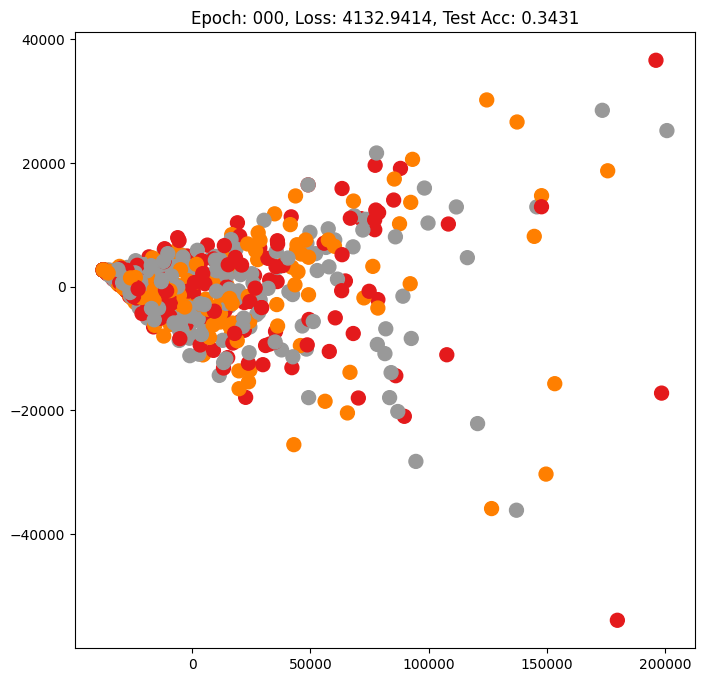

Epoch: 000, Loss: 4132.9414, Test Accurach: 0.3431


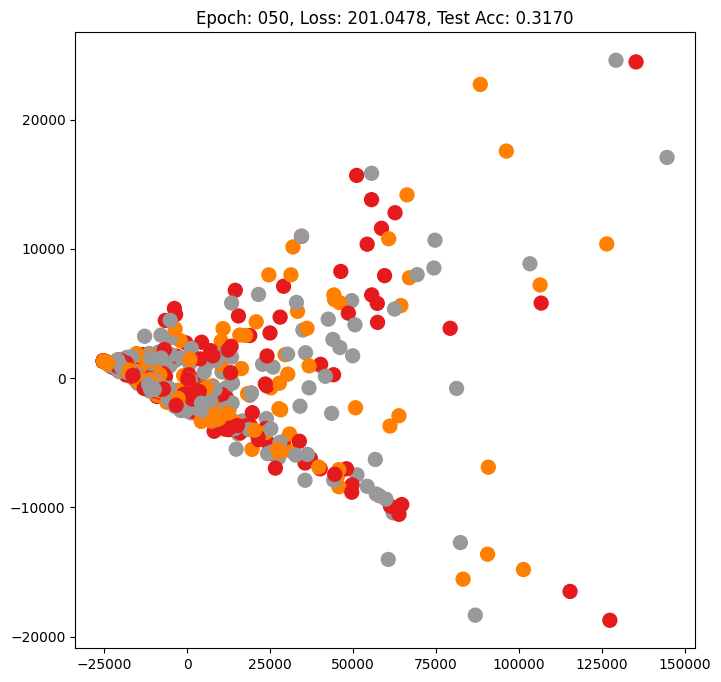

Epoch: 050, Loss: 201.0478, Test Accurach: 0.3170


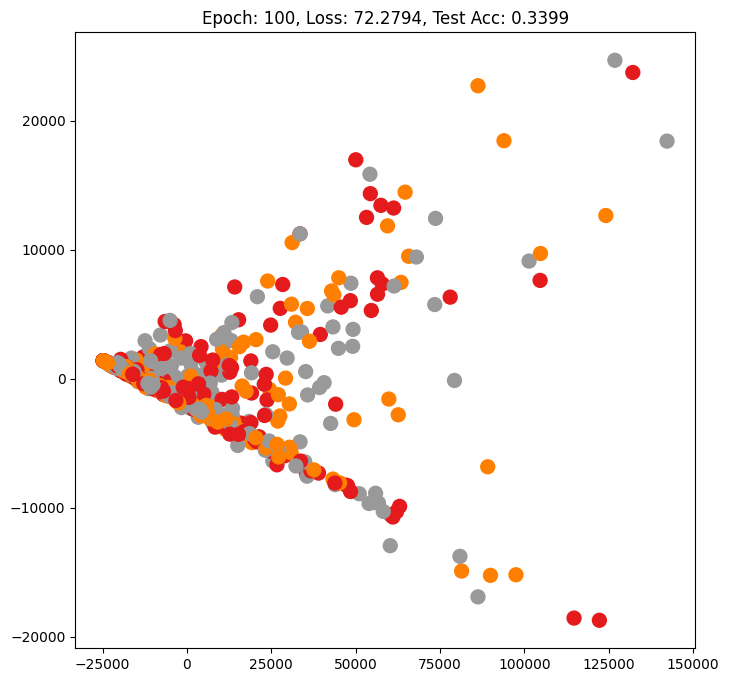

Epoch: 100, Loss: 72.2794, Test Accurach: 0.3399


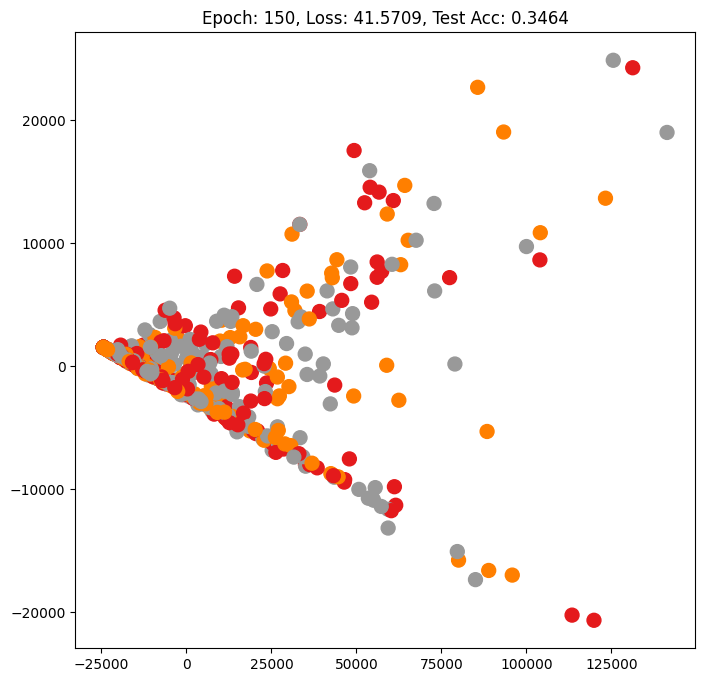

Epoch: 150, Loss: 41.5709, Test Accurach: 0.3464


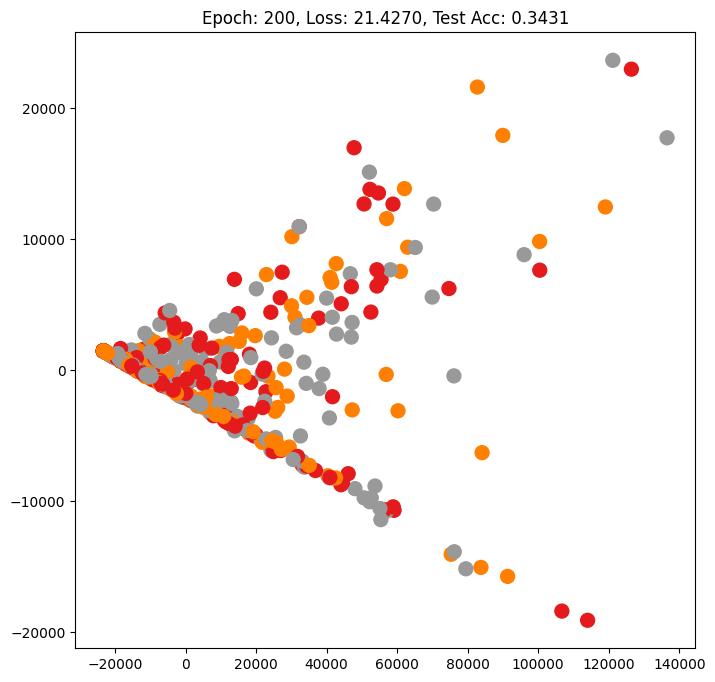

Epoch: 200, Loss: 21.4270, Test Accurach: 0.3431


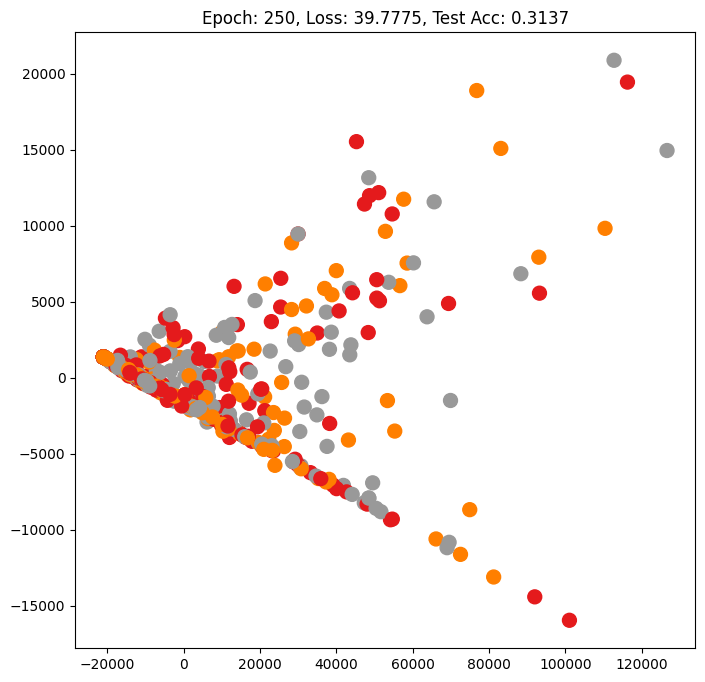

Epoch: 250, Loss: 39.7775, Test Accurach: 0.3137


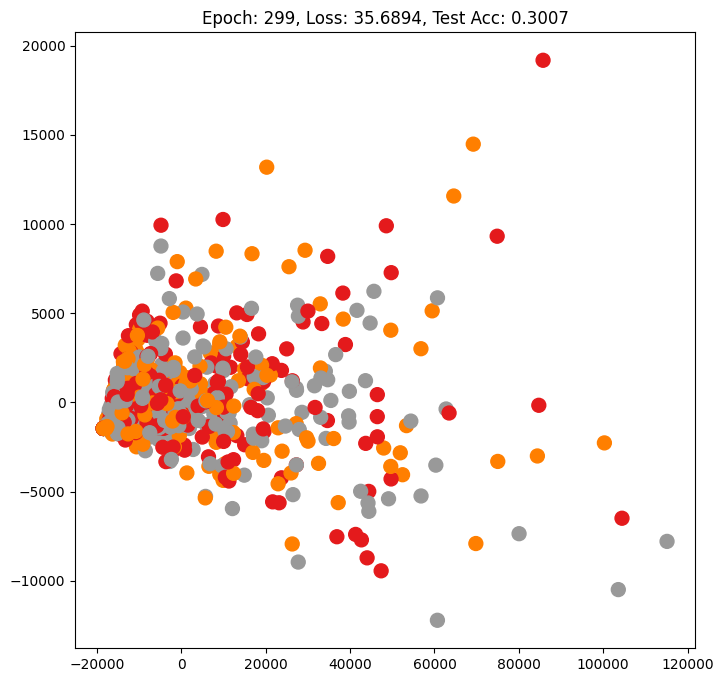

Epoch: 299, Loss: 35.6894, Test Accurach: 0.3007
--- GCN 학습 완료 ---


In [ ]:
# --- 4. Accuracy, 시각화 함수, 학습 함수 정의 ---
# Define the accuracy function
def accuracy(preds, labels):
    # preds는 out의 3차원 예측
    _, indices = torch.max(preds, dim=1)
    correct = (indices == labels).sum().item()
    return correct / len(labels)

# Visualize embeddings function
def visualize_embedding(h_np, color, epoch, loss, acc):
    # h_np는 NumPy 배열 형태의 임베딩 (16차원)
    # 2차원 시각화를 위해 PCA나 t-SNE가 필요하지만,
    # 여기서는 단순화를 위해 앞의 2개 차원만 사용하거나 (단순) PCA를 사용합니다.
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    h_2d = pca.fit_transform(h_np)

    plt.figure(figsize=(8, 8))
    plt.scatter(h_2d[:, 0], h_2d[:, 1], c=color, cmap="Set1", s=100)
    plt.title(f"Epoch: {epoch:03d}, Loss: {loss.item():.4f}, Test Acc: {acc:.4f}")
    plt.show()

# Training function
# 'data.trin_mask'와 'data.test_mask'를 사용하여 loss와 acc를 계산하도록 수정
def train(data):
    model.train()  # Set the model to training mode
    optimizer.zero_grad()  # Clear gradients
    out, h = model(data.x, data.edge_index)  # Perform a single forward pass

    # 1. train_mask가 True인 노드의 인덱스만 추출합니다.
    # torch.nonzero()는 (N, 1) 형태의 텐서를 반환하므로, .squeeze()로 1차원 벡터로 만듭니다.
    train_indices = data.train_mask.nonzero(as_tuple=True)[0]

    # 2. loss 계산 시 추출된 정수 인덱스(train_indices)를 사용합니다.
    # 이제 out과 data.y에서 오류 없이 학습 노드만 정확히 선택됩니다.
    loss = criterion(out[train_indices], data.y[train_indices])  # Compute the loss solely based on the training nodes

    loss.backward()  # Derive gradients
    optimizer.step()  # Update parameters based on gradients

    #ACC는 평가 노드(test_mask)에 대해서만 계산
    # GCN은 일반적으로 tset_mask를 사용합니다. 제공된 코드의 '~data.train.mask' 대신 사
    test_indices = data.test_mask.nonzero(as_tuple=True)[0]
    acc = accuracy(out[test_indices], data.y[test_indices])  # Evaluate accuracy on non-training nodes

    return  loss, out, h, acc # h(임베딩) 추가 반환

# --- 5. 모델 초기화 (수정된 부분) ---
# in_channels=10, out_channels=3은 이미 고정되었찌만, 데이터셋 정보를 사용합니다.
model = GCN(data.num_features, hidden_channels=16, out_channels=data.num_classes)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Define optimizer

print("--- GCN 학습 시작 ---")
frames = []
for epoch in range(300):
    loss, out, h, acc = train(data)  # Assuming 'karate_club' is the input data

    # Visualize every 100 epochs only in Colab.
    if epoch % 50 == 0 or epoch == 299: #50 epoch마다 시각화
        h_np = h.detach().cpu().numpy() #임베딩을 Numpy로 변환
        y_np = data.y.cpu().numpy()     #라벨을 Numpy로 변환

        #시각호 실행
        visualize_embedding(h_np, color=y_np, epoch=epoch, loss=loss, acc=acc)

        print(f"Epoch: {epoch:03d}, Loss: {loss.item():.4f}, Test Accurach: {acc:.4f}")
        time.sleep(0.1)

print("--- GCN 학습 완료 ---")